# **Lesson4: Computer Vision Fundamentals**
## Color Selection
To get the white lane line I make the threshold array. The value of pixel which is less than the threshold will be rewrited to "0". So it will be turned to black color.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

type: <class 'numpy.ndarray'>
dimensions: (540, 960, 3)


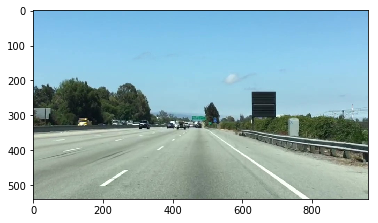

In [3]:
img = mpimg.imread('test.jpg')
plt.imshow(img)
print("type: {}\ndimensions: {}".format(type(img), img.shape))

In [4]:
ysize = img.shape[0]
xsize = img.shape[1]

color_select = np.copy(img)

In [5]:
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

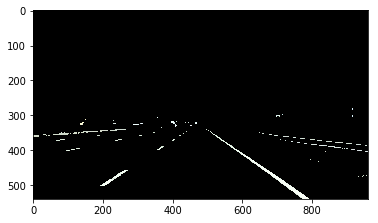

In [6]:
# Bit operation => the output value is 0 or 1.
color_thresholds = (img[:,:,0] < rgb_threshold[0]) \
                    | (img[:,:,1] < rgb_threshold[1]) \
                    | (img[:,:,2] < rgb_threshold[2])

color_select[color_thresholds] = [0,0,0]

plt.imshow(color_select)
plt.show()

## Region Masking

In [7]:
left_bottom = [0, ysize]
right_bottom = [xsize, ysize]
apex = [xsize/2, ysize*3/5]

fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]),(left_bottom[1], right_bottom[1]), 1)

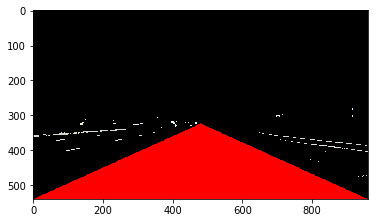

In [8]:
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) \
                    & (YY > (XX*fit_right[0] +fit_right[1])) \
                    & (YY < (XX*fit_bottom[0] + fit_bottom[1]))
color_select[region_thresholds] = [255, 0, 0]
plt.imshow(color_select)

## Combine Color Selection and  Region Masking

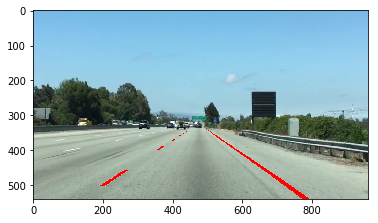

In [51]:
line_image = np.copy(img)
line_image[~color_thresholds  & region_thresholds] = [255, 0, 0]
plt.imshow(line_image)

## Canny Edge Detection

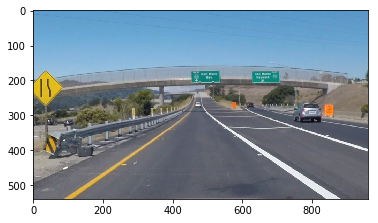

In [52]:
image = mpimg.imread('exit-ramp.jpg')
plt.imshow(image)

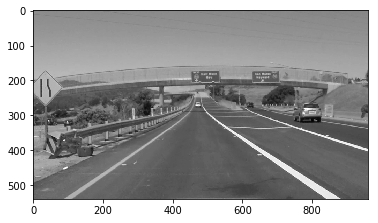

In [53]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

In [54]:
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

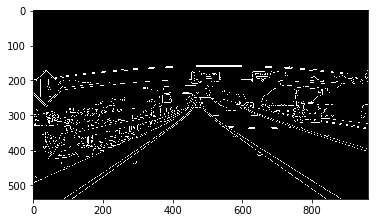

In [55]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')

## Filter Out Noises

In [91]:
# Helper function
def vertices(image):
    imshape = image.shape
    c_vertical = imshape[0]/2
    c_horizontal = imshape[1]/2
    return np.array([[(0,imshape[0]),(c_horizontal-20, c_vertical), (c_horizontal+20, c_vertical), (imshape[1],imshape[0])]], dtype=np.int32)

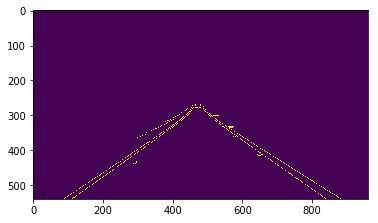

In [92]:
# Create a masked edges image using cv2.fillPoly() to mask
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

cv2.fillPoly(mask, vertices(image), ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

plt.imshow(masked_edges)

Now eges are represented by **dots** by using Canny Edge Detection.
To find **lines** next I connect dots.
- First I need to adopt "a model of a line".
- Second I fit that model to the assortment of dots in my edge detected image.

The line model I use is **y = mx + b.**

## Hough Transform
##### Using Hough Transform to find lines from Canny Edges.
    Image Space(Canny Edges) :     a line is plotted as "x versus y". (y = mx + b)
    Parameter Space(Hough Space) : same line is represented by "m versus b" instead.

The Hough Transform is just a conversion from image space to Hough Space. **The point is take parameter from line model and put it into parameter space.** So, the characterization of a line in image space will be a single point at the position (m, b) in Hough space.

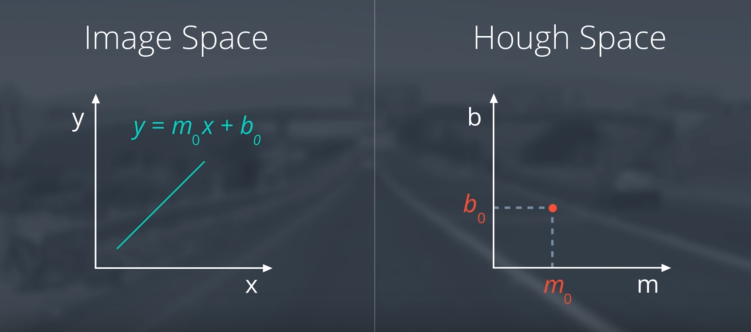
(Image captured from Udacity contents)

Now I have dots in my edge detected image(Canny Edge Detected Image). I can consider them as a line in Hough Space. And where many lines in Hough Space intersect means a collection of points that describe a line in image space.

##### Problem
I have a problem though with equasion of y = mx + b. Vertical lines have infinite slope in m-b representation.

So I need a new parametarization. I redefine the line in polar coordinates.
- ρ: the perpendicular distance of the line from the origin.
- θ: the angle the line away from the horizontal

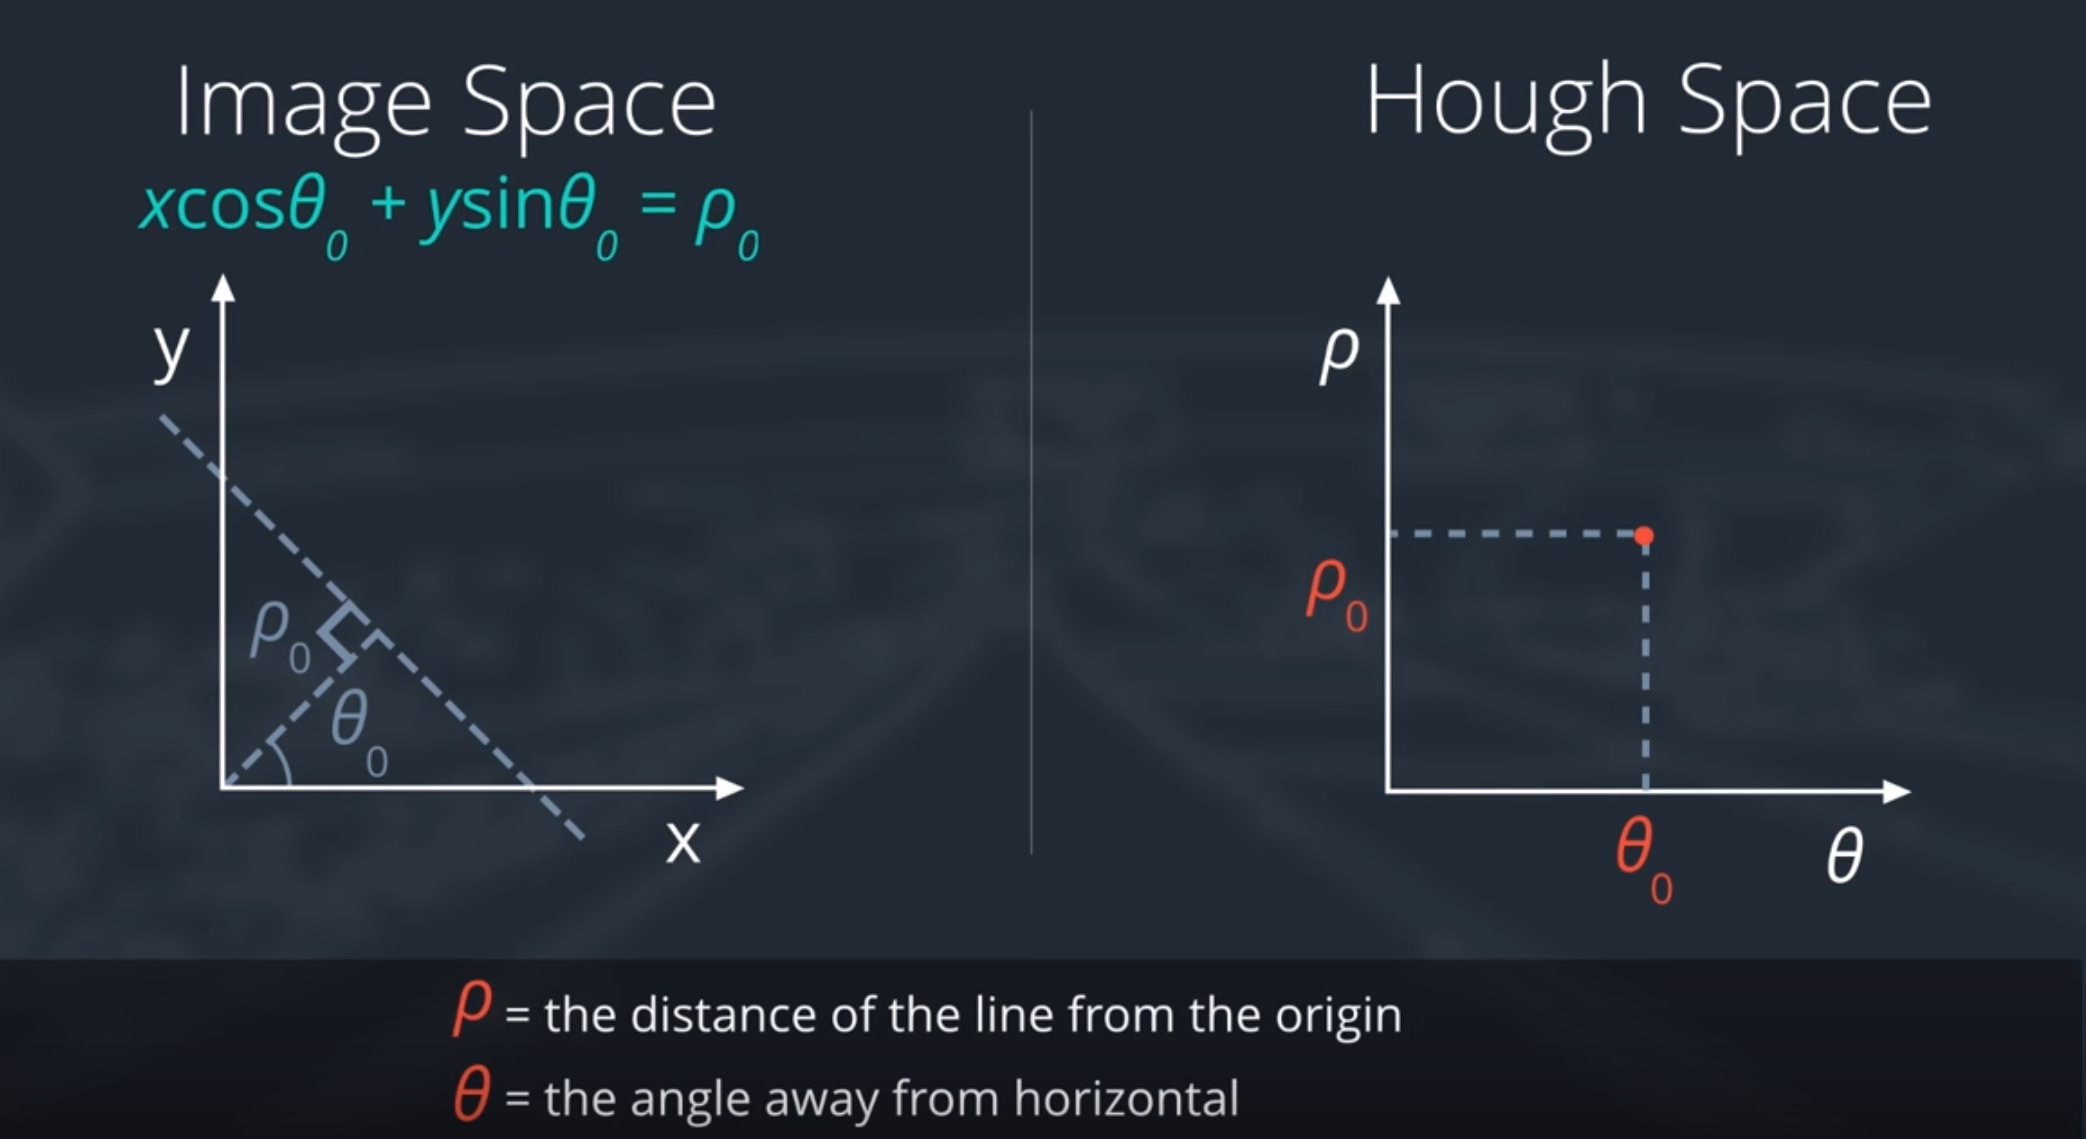
(Image captured from Udacity contents)

##### Parameters of cv2.HoughLinesP function
To specify some parameters to say what kind of lines I want to detect
(i.e. long lines, short lines, bendy lines, dashed lines,...)
 - rho:	units of pixels
 - theta:	1 degree (units of radians)
 - threshold:	minimum number of votes
 - np.array([]):	 placeholder
 - min_line_length:	minimum line in pixels
 - max_line_gap:	maximum distance between sebments that will allow to be connected into a single line.

In [88]:
rho = 1
theta = np.pi/180
threshold = 100
min_line_length = 30
max_line_gap = 5
line_image = np.copy(image) * 0 # creating a blank to draw lines on

# Run Hough on edge detected image
# The output of HoughLinesP is an array containing the endpoints(x1,x2,y1,y2) of all line segments detected
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

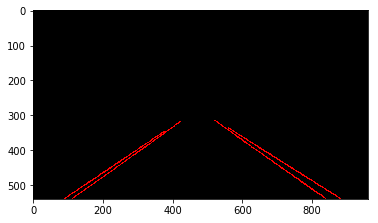

In [89]:
# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image, (x1,y1), (x2,y2), [255,0,0], 2)
plt.imshow(line_image)

## Combine filtered image and Hough lines

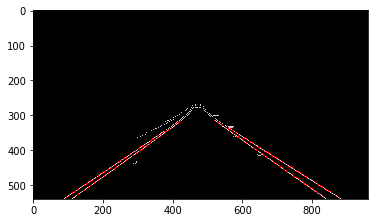

In [90]:
color_edges = np.dstack((edges, edges, edges))
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
plt.imshow(combo)